In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

## dTEC series reading

In [2]:
with open("./data/PTEX_DTEC_subseries.dat", "+r") as DTECin:
    file_lines = DTECin.readlines()
    total_series = int(file_lines[0])

    time_series = []
    dtec_series = []
    for n in tqdm(range(2, 2*total_series + 1, 2)):
        time_n_data = np.array(tuple(map(lambda x: datetime.fromisoformat(x), [time_stamp.strip() for time_stamp in file_lines[n-1].split(",")])))
        dtec_n_data = np.array(tuple(map(lambda x: float(x), file_lines[n].split(","))))

        time_series.append(time_n_data)
        dtec_series.append(dtec_n_data)

100%|██████████| 4339/4339 [00:01<00:00, 3425.09it/s]


## Outliers index reading

In [3]:
SeriesLabels = np.loadtxt("./data/PTEX_Outliers.dat", dtype = int, delimiter = ",", usecols = (1,))
ArgOutliers = np.argwhere(SeriesLabels == -1).flatten()
ArgNotOutliers = np.argwhere(SeriesLabels != -1).flatten()

## Visualization of sample of outliers

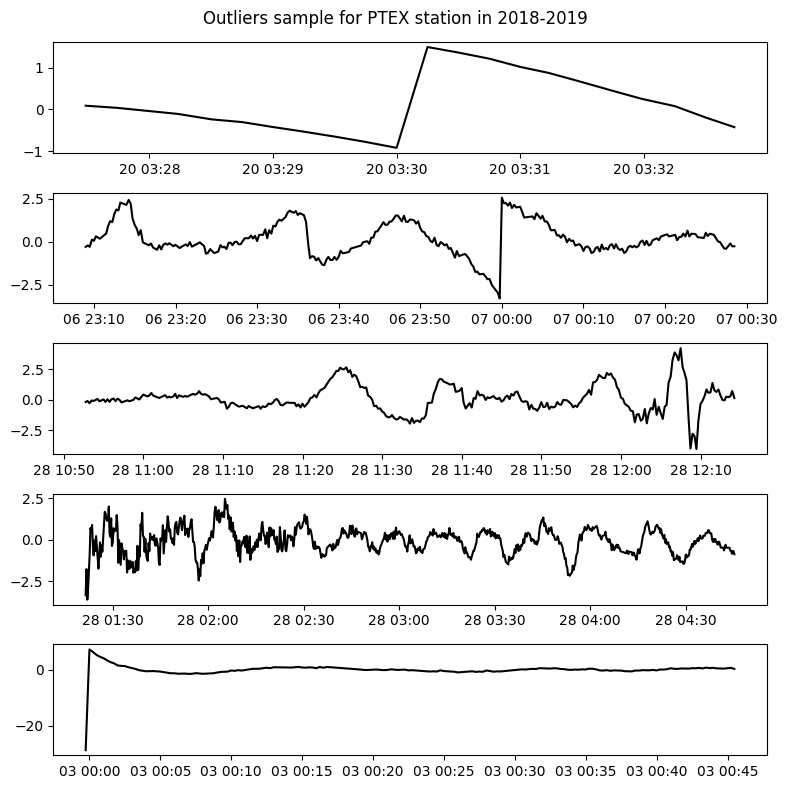

In [4]:
SizeSample = 5
SampleIndexOutlers = np.random.choice(ArgOutliers, size = SizeSample, replace = False)

FigOutliers, SubplotsOut = plt.subplots(nrows = SizeSample, ncols = 1, figsize = (8, 8))
for n, index in enumerate(SampleIndexOutlers):
    SubplotsOut[n].plot(time_series[index], dtec_series[index], "-k", linewidth = 1.5)

FigOutliers.suptitle("Outliers sample for PTEX station in 2018-2019")
FigOutliers.tight_layout()

## Visualization of samples per cluster without outliers

In [5]:
UniqueLabels = np.unique(SeriesLabels[ArgNotOutliers]).astype(int)

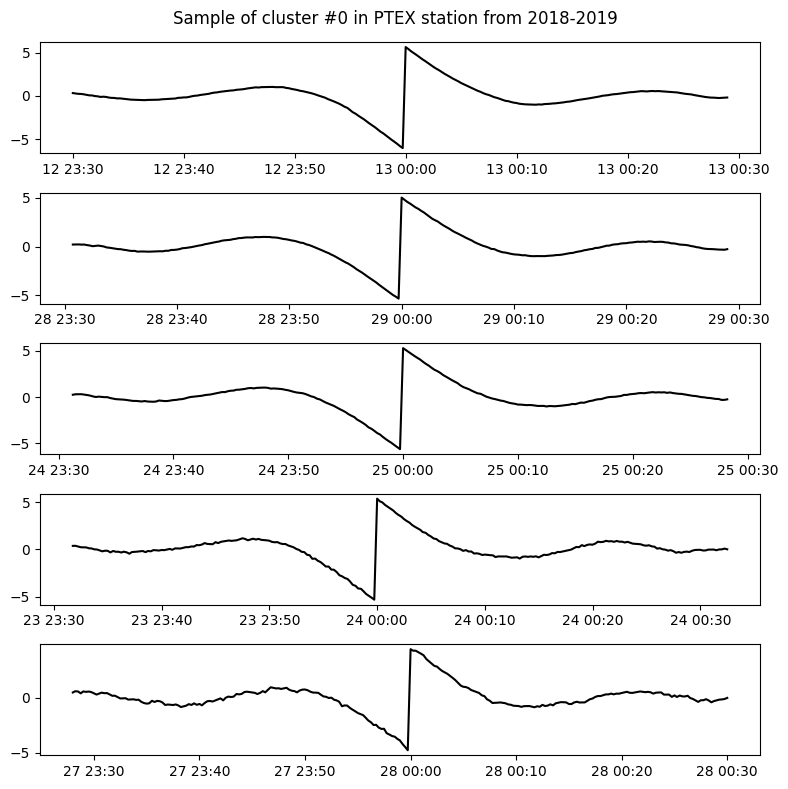

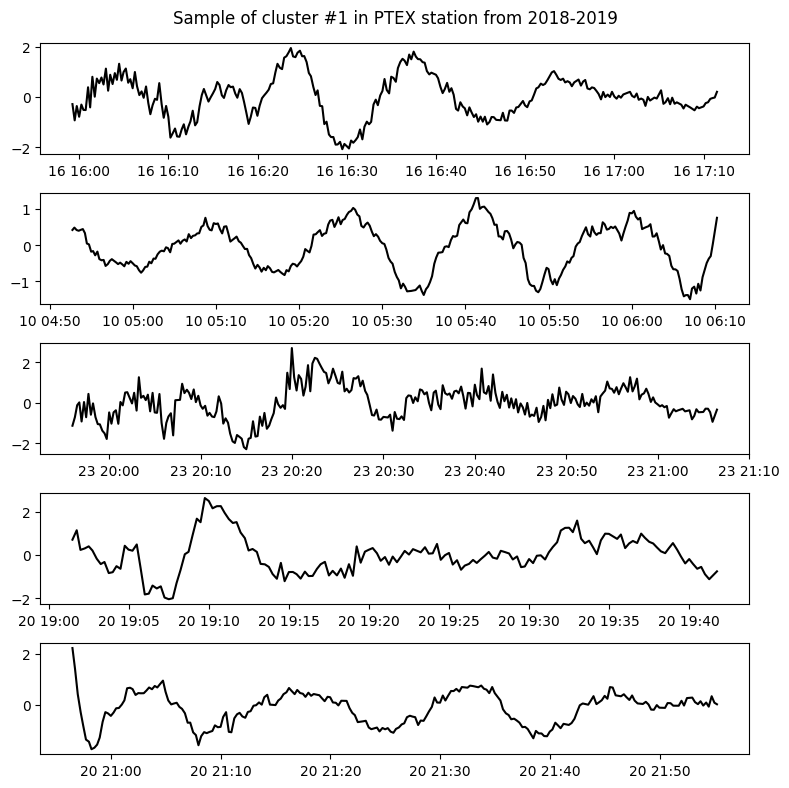

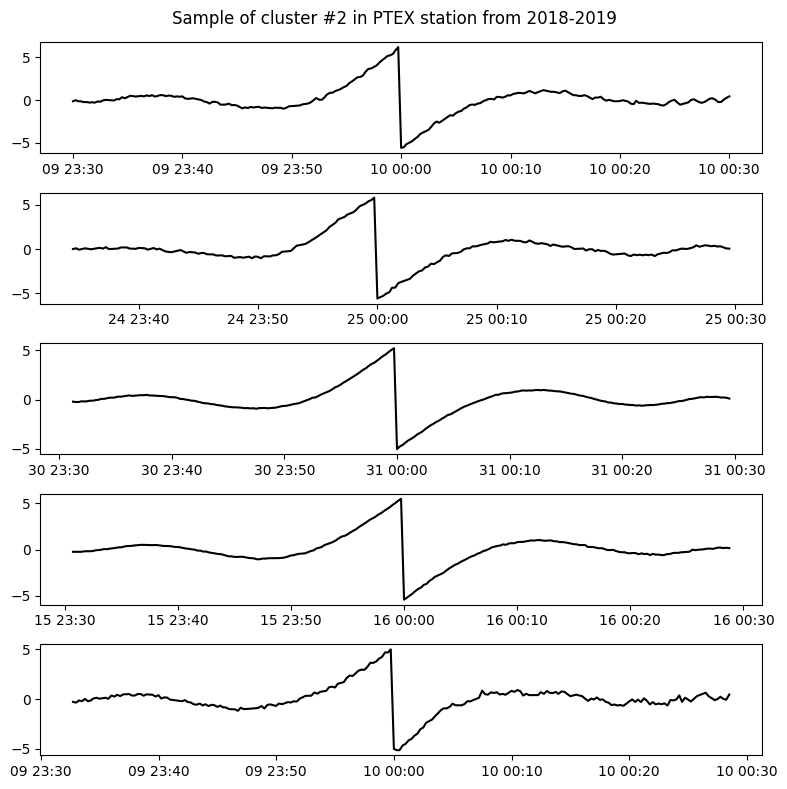

In [6]:
for label in UniqueLabels:
    SampleIndexByLabel = np.random.choice(np.argwhere(SeriesLabels == label).flatten(), size = SizeSample, replace = False)

    FigLabel, SubplotsLabel = plt.subplots(nrows = SizeSample, ncols = 1, figsize = (8, 8))
    for n, index in enumerate(SampleIndexByLabel):
        SubplotsLabel[n].plot(time_series[index], dtec_series[index], "-k", linewidth = 1.5)

    FigLabel.suptitle(f"Sample of cluster #{label} in PTEX station from 2018-2019")
    FigLabel.tight_layout()

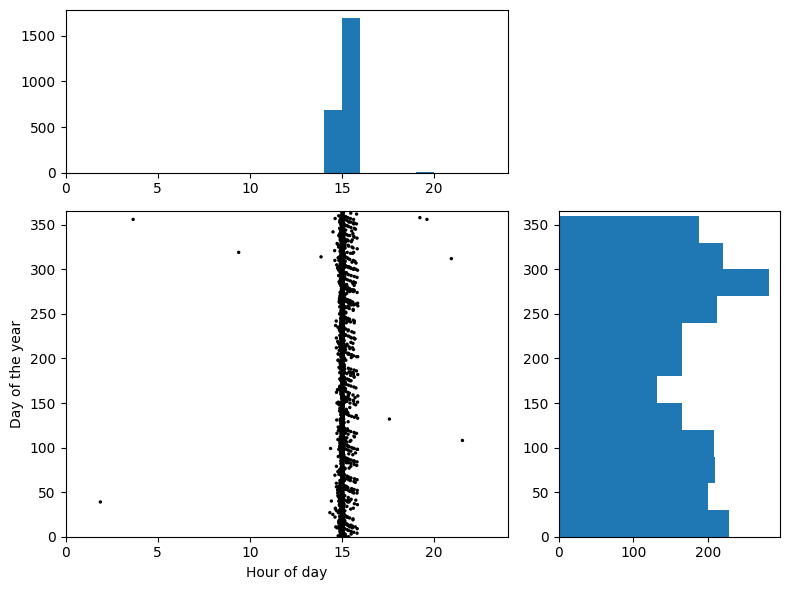

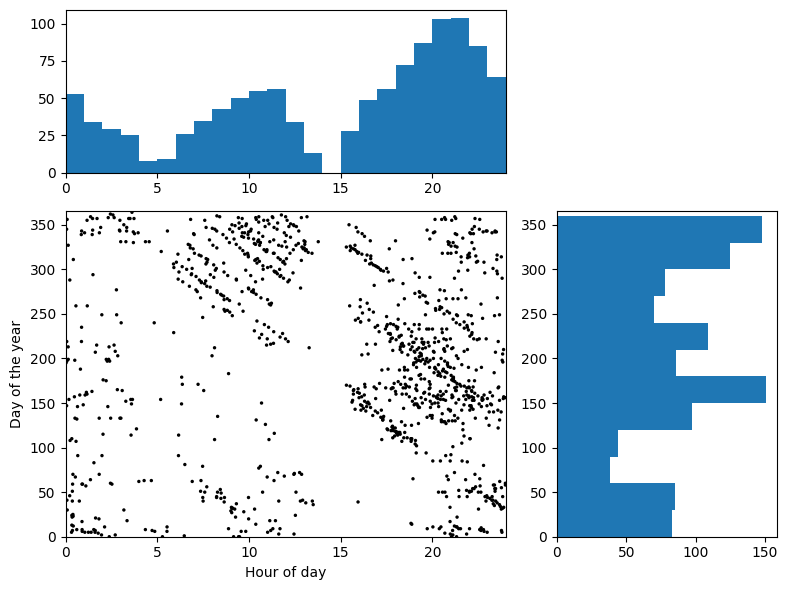

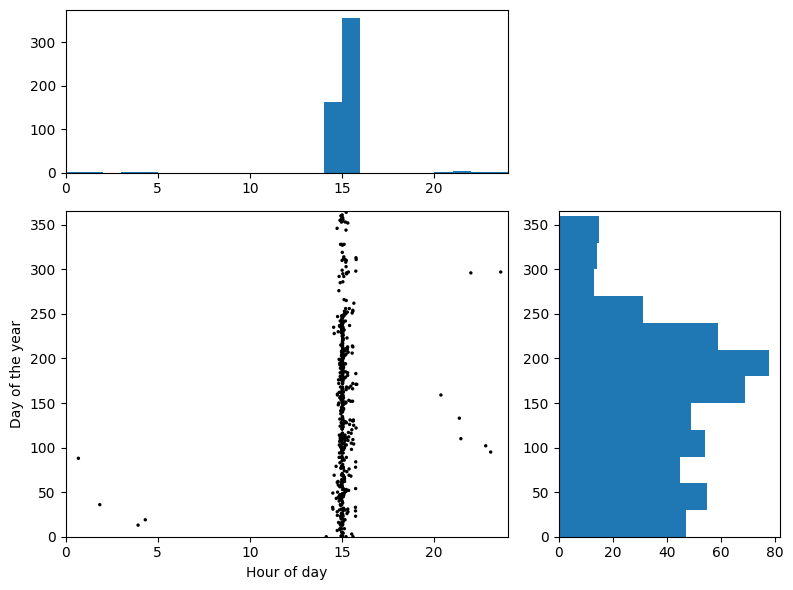

In [7]:
for label in UniqueLabels:
    SampleIndexByLabel = np.argwhere(SeriesLabels == label).flatten()
    HourPositions, DayMonthPositions = [], []
    for index in SampleIndexByLabel:
        current_prom_series = time_series[index]

        HourPosition = current_prom_series[0] + 0.5*(current_prom_series[0] - current_prom_series[-1])
        HourPosition = HourPosition.hour + HourPosition.minute/60.0 + HourPosition.second/3600.0

        DayMonthPosition = current_prom_series.astype('datetime64[D]')[current_prom_series.size//2]

        HourPositions.append(HourPosition)
        DayMonthPositions.append(DayMonthPosition)

    HourPositions = np.array(HourPositions, dtype = float)
    HourPositions = HourPositions - 8.0
    HourPositions = np.where(HourPositions < 0, HourPositions + 24.0, HourPositions)

    DayMonthPositions = np.array(DayMonthPositions, dtype = "datetime64[D]")
    TransDays = (DayMonthPositions - DayMonthPositions.min()).astype("timedelta64[D]").astype(int)
    TransDays = TransDays % 365

    Figure, Subplot = plt.subplot_mosaic([["HourHist", "."],
                                          ["Scatter", "DayMonthHist"]],
                                          height_ratios = (1,2),
                                          width_ratios = (2,1),
                                          figsize = (8, 6))

    Subplot["HourHist"].hist(HourPositions, fc = "blue", ec = "black", bins = tuple(range(0, 25)))[1]
    Subplot["DayMonthHist"].hist(TransDays, fc = "blue", ec = "black", bins = tuple(range(0, 365, 30)), orientation = "horizontal")[1]
    Subplot["Scatter"].scatter(HourPositions, TransDays, fc = "black", ec = "None", s = 6)

    Subplot["Scatter"].set_xlim(0, 24)
    Subplot["Scatter"].set_ylim(0, 365)
    Subplot["HourHist"].set_xlim(0, 24)
    Subplot["DayMonthHist"].set_ylim(0, 365)

    Subplot["Scatter"].set_xlabel("Hour of day")
    Subplot["Scatter"].set_ylabel("Day of the year")

    Figure.tight_layout()